In [70]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import walsdata
from walsdata import s229d, s280d
import langmap
import geo
import origins

In [2]:
import warnings
warnings.filterwarnings('ignore', 'The least populated class')

### Geographical groups

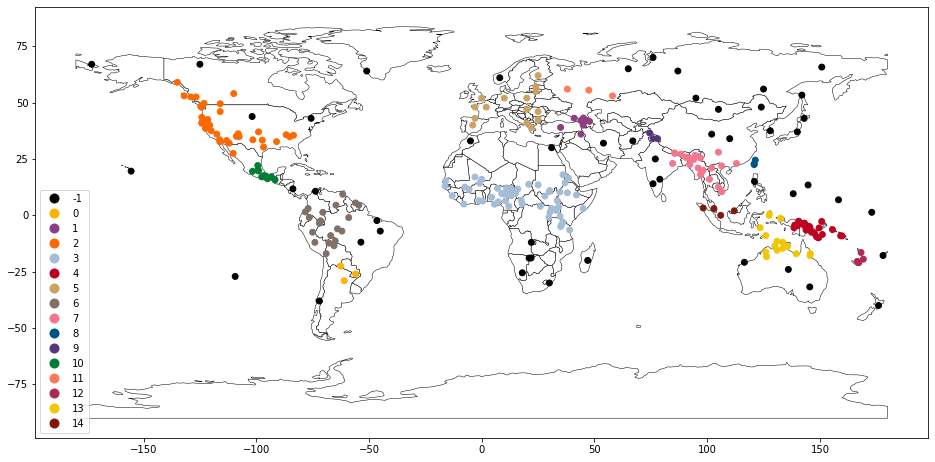

In [3]:
langmap.plot(s280d.langs, labels=geo.labels)

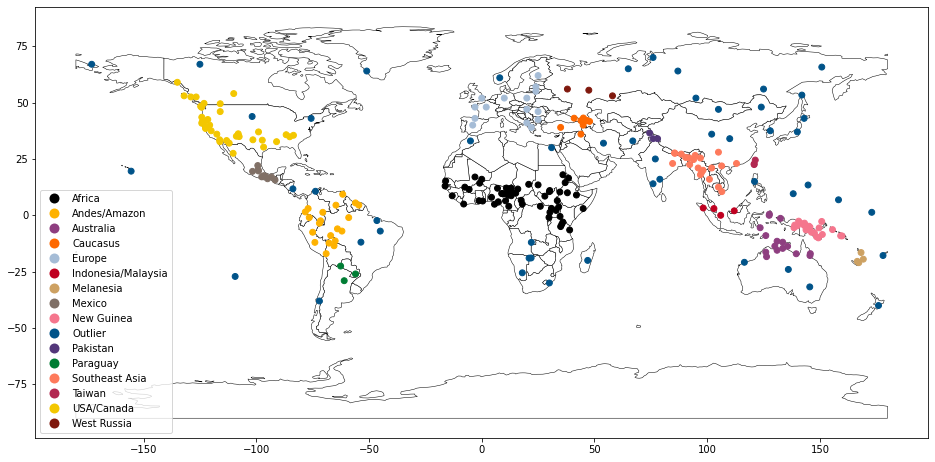

In [4]:
langmap.plot(s280d.langs, labels=geo.region_labels)

### Getting families and regions ready for supervised learning

In [5]:
origins280 = s280d.langs[['ID', 'Family', 'Genus']].set_index('ID')
origins280.index.name = 'Language_ID'
origins280.columns = ['family', 'genus']
origins280['region'] = geo.region_labels

In [6]:
origins280

,family,genus,region
Language_ID,,,
abi,Guaicuruan,South Guaicuruan,Paraguay
abk,Northwest Caucasian,Northwest Caucasian,Caucasus
aco,Keresan,Keresan,USA/Canada
aeg,Afro-Asiatic,Semitic,Outlier
ain,NaN,NaN,Outlier
...,...,...,...
yur,Algic,Yurok,USA/Canada
zan,Niger-Congo,Ubangi,Africa
zqc,Mixe-Zoque,Mixe-Zoque,Mexico


In [7]:
origins229 = s229d.langs[['ID', 'Family', 'Genus']].set_index('ID')
origins229.index.name = 'Language_ID'
origins229.columns = ['family', 'genus']
origins229['region'] = origins280.region

In [8]:
origins229

,family,genus,region
Language_ID,,,
abk,Northwest Caucasian,Northwest Caucasian,Caucasus
aeg,Afro-Asiatic,Semitic,Outlier
ain,NaN,NaN,Outlier
akn,Niger-Congo,Kwa,Africa
ala,Sepik,Sepik Hill,New Guinea
...,...,...,...
yko,Yukaghir,Yukaghir,Outlier
yor,Niger-Congo,Defoid,Africa
yuc,NaN,NaN,USA/Canada


Now I want to discard any groups that are too small to provide good estimates.

In [9]:
origins_df = origins280

In [10]:
min_group_size = 5

In [11]:
family_counts = origins_df.family.value_counts()

In [12]:
good_family_counts = family_counts[family_counts >= min_group_size]
good_family_counts

Austronesian         26
Niger-Congo          23
Indo-European        20
Afro-Asiatic         15
Sino-Tibetan         15
Trans-New Guinea     11
Altaic                8
Austro-Asiatic        6
Uto-Aztecan           6
Eastern Sudanic       6
Nakh-Daghestanian     5
Penutian              5
Pama-Nyungan          5
Name: family, dtype: int64

In [13]:
good_families = list(good_family_counts.index)

In [14]:
genus_counts = origins_df.genus.value_counts()

In [15]:
good_genus_counts = genus_counts[genus_counts >= min_group_size]
good_genus_counts

Oceanic    13
Bantoid     6
Name: genus, dtype: int64

In [16]:
good_genera = list(good_genus_counts.index)

In [17]:
region_counts = origins_df.region[origins_df.region != 'Outlier'].value_counts()

In [18]:
good_region_counts = region_counts[region_counts >= min_group_size]
good_region_counts

Africa            55
USA/Canada        37
New Guinea        25
Southeast Asia    21
Andes/Amazon      20
Australia         16
Europe            15
Caucasus          10
Mexico            10
Name: region, dtype: int64

In [19]:
good_regions = sorted(list(good_region_counts.index))

In [20]:
origins_good = origins_df.copy()

In [21]:
origins_good.family = origins_good.family.where(
    origins_good.family.isin(good_families), np.nan
)
origins_good.genus = origins_good.genus.where(
    origins_good.genus.isin(good_genera), np.nan
)
origins_good.region = origins_good.region.where(
    origins_good.region.isin(good_regions), 'Outlier'
)

In [22]:
origins_good

,family,genus,region
Language_ID,,,
abi,NaN,NaN,Outlier
abk,NaN,NaN,Caucasus
aco,NaN,NaN,USA/Canada
aeg,Afro-Asiatic,NaN,Outlier
ain,NaN,NaN,Outlier
...,...,...,...
yur,NaN,NaN,USA/Canada
zan,Niger-Congo,NaN,Africa
zqc,NaN,NaN,Mexico


In [23]:
good_categories = [good_families, good_genera, good_regions]

In [24]:
values = s280d.values_scaled_imputed

### Datasets

Similar to my scrambled clustering baseline, I'm making a dataset based on a scrambled table of families and regions. This should give an idea of how many "good" models will show up just by chance.

In [25]:
origins_scrambled = origins_good.copy()
state = np.random.RandomState(280)
for col in origins_scrambled:
    origins_scrambled[col] = state.permutation(origins_scrambled[col].values)

In [26]:
origins_scrambled

,family,genus,region
Language_ID,,,
abi,NaN,NaN,Outlier
abk,Austronesian,NaN,Southeast Asia
aco,Trans-New Guinea,NaN,Africa
aeg,Austronesian,NaN,USA/Canada
ain,Austronesian,NaN,New Guinea
...,...,...,...
yur,NaN,NaN,USA/Canada
zan,NaN,NaN,Outlier
zqc,Niger-Congo,NaN,Africa


In [27]:
baseline = origins.OriginDataset(values, origins_scrambled, good_categories)

And this is the dataset for the real model

In [28]:
real = origins.OriginDataset(values, origins_good, good_categories)

### Logistic regression on some features

In [29]:
real.logistic_model('81A_1')

Feature order__sov:
    Training score: 0.349
    Testing score: 0.203
    Observed rate: 0.418
    Inferred innate rate: 0.497
    Coefficients:
        Austronesian     : -1.95
        Niger-Congo      : -1.69
        Indo-European    : -0.399
        Afro-Asiatic     : -0.0936
        Sino-Tibetan     : 0.529
        Trans-New Guinea : 0.956
        Altaic           : 1.37
        Austro-Asiatic   : -0.827
        Uto-Aztecan      : 0.554
        Eastern Sudanic  : -0.99
        Nakh-Daghestanian: 0.527
        Penutian         : -0.483
        Pama-Nyungan     : -0.375
        Oceanic          : -0.98
        Bantoid          : -0.377
        Africa           : -0.395
        Andes/Amazon     : 0.329
        Australia        : -1.25
        Caucasus         : 0.514
        Europe           : -1.29
        Mexico           : -1.52
        New Guinea       : 1.41
        Southeast Asia   : -0.193
        USA/Canada       : -0.367

In [30]:
real.logistic_model('19A_5')

Feature present__th_sounds:
    Training score: 0.157
    Testing score: 0.0446
    Observed rate: 0.0964
    Inferred innate rate: 0.0991
    Coefficients:
        Austronesian     : 0.758
        Niger-Congo      : -0.402
        Indo-European    : 0.293
        Afro-Asiatic     : -0.73
        Sino-Tibetan     : 0.303
        Trans-New Guinea : -0.311
        Altaic           : 0.203
        Austro-Asiatic   : -0.271
        Uto-Aztecan      : -0.458
        Eastern Sudanic  : 0.284
        Nakh-Daghestanian: -0.125
        Penutian         : -0.318
        Pama-Nyungan     : 0.475
        Oceanic          : 0.377
        Bantoid          : 0.528
        Africa           : 0.134
        Andes/Amazon     : -0.218
        Australia        : -0.791
        Caucasus         : -0.373
        Europe           : 0.49
        Mexico           : 1.48
        New Guinea       : -1.02
        Southeast Asia   : 0.245
        USA/Canada       : -0.164

### Finding the best regularization penalty

In [31]:
real.logistic_model('81A_1', cv=True)

Feature order__sov:
    Training score: 0.388
    Testing score: 0.211
    Observed rate: 0.418
    Inferred innate rate: 0.527
    Coefficients:
        Austronesian     : -2.49
        Niger-Congo      : -2.26
        Indo-European    : -0.38
        Afro-Asiatic     : -0.238
        Sino-Tibetan     : 0.61
        Trans-New Guinea : 1.18
        Altaic           : 1.76
        Austro-Asiatic   : -1.24
        Uto-Aztecan      : 0.791
        Eastern Sudanic  : -1.49
        Nakh-Daghestanian: 0.783
        Penutian         : -0.623
        Pama-Nyungan     : -0.56
        Oceanic          : -1.2
        Bantoid          : -0.465
        Africa           : -0.359
        Andes/Amazon     : 0.261
        Australia        : -1.61
        Caucasus         : 0.521
        Europe           : -1.83
        Mexico           : -2.12
        New Guinea       : 1.58
        Southeast Asia   : -0.336
        USA/Canada       : -0.52

In [32]:
real.logistic_model('19A_5', cv=True)

Feature present__th_sounds:
    Training score: 0.0712
    Testing score: -0.0232
    Observed rate: 0.0964
    Inferred innate rate: 0.11
    Coefficients:
        Austronesian     : 0.332
        Niger-Congo      : -0.117
        Indo-European    : 0.128
        Afro-Asiatic     : -0.227
        Sino-Tibetan     : 0.114
        Trans-New Guinea : -0.149
        Altaic           : 0.042
        Austro-Asiatic   : -0.0659
        Uto-Aztecan      : -0.103
        Eastern Sudanic  : 0.085
        Nakh-Daghestanian: -0.0388
        Penutian         : -0.0901
        Pama-Nyungan     : 0.108
        Oceanic          : 0.209
        Bantoid          : 0.114
        Africa           : -0.0352
        Andes/Amazon     : -0.102
        Australia        : -0.249
        Caucasus         : -0.102
        Europe           : 0.174
        Mexico           : 0.526
        New Guinea       : -0.381
        Southeast Asia   : 0.0933
        USA/Canada       : -0.133

### Logistic regression baseline on all features

Similar to my scrambled clustering baseline, this is logistic regression of all categorical features based on a scrambled table of families and regions. This should give an idea of how many "good" models will show up just by chance.

In [33]:
baseline.full_logistic_model()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
voicing__plosives,0.053408,-0.058233,0.614286,0.634816,0.916153,-0.087572,-0.196835,0.384569,0.292027,0.484328,...,0.208570,-0.175258,-0.230076,-0.642100,-0.710325,-0.344129,-0.307226,0.003249,-0.066757,-0.092734
voicing__fricatives,0.081372,-0.098391,0.360714,0.309937,1.256270,0.228147,0.268508,0.112586,-0.344205,0.654640,...,-0.372403,0.233618,0.006210,-0.301057,0.815563,-0.539065,-0.273462,-0.445464,0.385880,0.409083
plosive_gap__other,0.051488,-0.030364,0.428571,0.405219,1.100851,0.096084,0.212001,-0.311348,-0.384321,-0.569994,...,-0.280904,0.118654,0.088029,0.504081,0.595904,0.234816,0.207705,0.159898,0.169740,0.074491
plosive_gap__p,0.109014,-0.099667,0.071429,0.061120,1.181630,0.166895,-0.299907,-0.169034,0.508443,0.465084,...,-0.264169,0.289713,0.770111,-0.471902,0.504328,0.250581,-0.418699,0.634356,-0.525544,0.486469
plosive_gap__g,0.115691,-0.280031,0.064286,0.087796,0.713818,-0.337127,-0.271494,-0.779996,0.417721,-0.024702,...,-0.182607,-0.227834,0.608727,-0.615885,-0.390401,-0.398577,-0.496424,-0.033847,-0.089232,-0.925501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.106522,-0.022105,0.078571,0.087835,0.885538,-0.121560,0.511147,0.791090,-0.609295,-0.087675,...,0.506156,-0.500046,-0.267520,-0.666192,-0.398874,-0.519063,0.518432,-0.478320,-0.285814,-0.190015
negative_word__final,0.080415,-0.121958,0.078571,0.089155,0.871169,-0.137919,-0.535245,-0.459516,0.257459,-0.036843,...,-0.353914,0.747817,-0.254105,-0.617932,-0.374375,-0.486285,0.117403,0.047608,0.392103,-0.461319
negative_word__second,0.178336,-0.117001,0.142857,0.115416,1.277390,0.244819,-0.567768,-0.008742,-0.435592,0.777007,...,-0.487277,-0.751269,1.449791,0.234774,0.225046,-0.606568,-0.017216,0.359472,1.152745,0.441888
negative_word__other,0.143595,-0.226714,0.075000,0.054150,1.416255,0.348016,-0.128773,-0.578717,0.700864,0.103014,...,-0.151316,-0.339443,0.471934,-0.390902,0.532024,0.901147,-0.375830,0.683663,-0.467700,0.268571


In [34]:
cat_results_scrambled = baseline.full_logistic_model(cv=True)

In [35]:
cat_results_scrambled

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
voicing__plosives,0.027043,-0.021357,0.614286,0.615543,0.994702,-0.005312,-0.134205,0.198578,0.137265,0.203329,...,0.078322,-0.049271,-0.067928,-0.295783,-0.255650,-0.124165,-0.094505,0.073350,0.024948,-0.000744
voicing__fricatives,0.043018,-0.039343,0.360714,0.324753,1.173217,0.159750,0.157153,0.039795,-0.174760,0.291453,...,-0.090466,0.119426,0.031072,-0.135534,0.308487,-0.226819,-0.129058,-0.266565,0.172253,0.282074
plosive_gap__other,0.025967,-0.008398,0.428571,0.423038,1.022890,0.022632,0.144987,-0.166235,-0.190121,-0.258636,...,-0.102163,0.019801,-0.003112,0.235377,0.216597,0.079565,0.050898,0.032363,0.031410,-0.000284
plosive_gap__p,0.039422,-0.029136,0.071429,0.072368,0.986027,-0.014072,-0.106988,-0.074748,0.170278,0.155811,...,-0.058482,0.069344,0.276228,-0.150547,0.108778,0.071321,-0.119834,0.206817,-0.171206,0.161596
plosive_gap__g,0.044686,-0.197075,0.064286,0.080598,0.783701,-0.243727,-0.102905,-0.249010,0.161083,-0.010491,...,-0.051564,-0.095068,0.260446,-0.165911,-0.089694,-0.110795,-0.127907,0.021686,-0.016355,-0.308994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.041799,-0.010341,0.078571,0.086377,0.901932,-0.103216,0.181349,0.343249,-0.185618,-0.032603,...,0.123711,-0.164444,-0.079290,-0.184263,-0.096844,-0.127298,0.201029,-0.158000,-0.053752,-0.046232
negative_word__final,0.034230,-0.103583,0.078571,0.089502,0.867458,-0.142188,-0.172370,-0.143705,0.120037,-0.028044,...,-0.076614,0.366878,-0.083701,-0.181420,-0.097218,-0.128479,0.034151,0.000868,0.128185,-0.185522
negative_word__second,0.147555,-0.071636,0.142857,0.127450,1.141031,0.131932,-0.429586,-0.002166,-0.291851,0.612569,...,-0.265919,-0.632517,1.147460,0.118594,0.108036,-0.387389,-0.050258,0.224451,0.820890,0.294230
negative_word__other,0.051376,-0.096887,0.075000,0.061382,1.239844,0.214986,-0.055044,-0.195285,0.210951,0.022484,...,-0.041652,-0.161172,0.156703,-0.125398,0.120685,0.270348,-0.100902,0.247847,-0.145514,0.066785


In [36]:
cat_results_scrambled.testing_score.describe()

count    87.000000
mean     -0.057490
std       0.085265
min      -0.632911
25%      -0.071264
50%      -0.041063
75%      -0.014390
max       0.099845
Name: testing_score, dtype: float64

### Logistic regression on all categorical features

In [37]:
real.full_logistic_model()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
voicing__plosives,0.215333,0.217916,0.614286,0.532592,1.397675,0.334810,0.687813,0.484572,0.714279,1.068457,...,-0.649601,1.644720,0.215423,-1.041782,0.317663,1.101001,-0.075246,0.034454,0.331299,-0.330213
voicing__fricatives,0.324724,0.204845,0.360714,0.334492,1.122630,0.115674,-0.043899,0.933139,1.529108,1.063894,...,0.920108,0.086788,-0.242519,-1.386608,1.206065,1.189401,-0.221265,-0.899518,0.004408,-1.858368
plosive_gap__other,0.242842,0.217416,0.428571,0.487654,0.787975,-0.238289,-0.689765,-0.506480,-0.785317,-1.091406,...,0.632256,-1.699161,-0.066376,0.983867,0.015901,-1.112519,0.331397,0.345591,-0.367477,0.502108
plosive_gap__p,0.255350,0.350595,0.071429,0.047337,1.548100,0.437028,-0.551027,-0.142977,-0.299031,1.306412,...,0.471872,1.283814,-0.457356,-0.381281,-0.175790,-0.235752,-0.284370,0.595670,-0.328668,-0.670329
plosive_gap__g,0.128042,-0.244989,0.064286,0.064975,0.988660,-0.011404,-0.090980,0.222917,-0.370693,-0.381388,...,-0.209149,-0.558406,0.868585,0.101795,-0.224151,-0.291578,0.288093,0.181127,1.350546,0.385357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.246078,0.232446,0.078571,0.069296,1.145264,0.135635,1.467514,-0.491181,-0.386604,0.195197,...,-0.129962,-0.383798,-0.020091,-0.195699,-0.235188,-0.303948,1.730490,-0.865565,-0.418297,0.715309
negative_word__final,0.128638,-0.180712,0.078571,0.065046,1.225672,0.203489,0.069360,0.123265,-0.370859,0.929482,...,-0.308376,0.647389,0.012656,0.976996,-0.224329,-0.291701,-0.363205,0.324857,0.425590,-0.808183
negative_word__second,0.191692,0.124703,0.142857,0.116886,1.259221,0.230493,0.002670,0.082131,0.380476,-0.989405,...,-0.450897,0.588408,-0.317918,1.140884,-0.392846,1.458066,0.004455,-0.572665,0.908802,-0.736048
negative_word__other,0.110223,-0.069739,0.075000,0.067158,1.126241,0.118885,-0.660966,-0.435737,-0.377971,0.267178,...,-0.124829,-0.559788,-0.580732,-0.484361,-0.259307,-0.297966,-0.396974,0.380914,0.412163,0.013705


In [38]:
cat_results = real.full_logistic_model(cv=True)

In [39]:
cat_results

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
voicing__plosives,0.230145,0.227161,0.614286,0.516163,1.492853,0.400689,0.916668,0.586925,0.790198,1.291865,...,-0.848300,1.794395,0.287732,-1.140772,0.347782,1.343823,-0.034114,0.112403,0.397272,-0.281664
voicing__fricatives,0.354336,0.202268,0.360714,0.334018,1.125023,0.117803,0.058990,1.079869,1.904107,1.292848,...,1.278994,-0.019141,-0.275127,-1.844607,1.602658,1.493749,-0.260618,-0.972430,-0.179934,-2.326631
plosive_gap__other,0.257008,0.225132,0.428571,0.498644,0.754078,-0.282260,-0.913097,-0.603436,-0.868065,-1.310855,...,0.833266,-1.835920,-0.108715,1.093709,0.032477,-1.342241,0.335175,0.316449,-0.424177,0.480354
plosive_gap__p,0.255350,0.350592,0.071429,0.047338,1.548039,0.436989,-0.551028,-0.143032,-0.299049,1.306424,...,0.471813,1.283799,-0.457386,-0.381315,-0.175808,-0.235765,-0.284399,0.595654,-0.328685,-0.670339
plosive_gap__g,0.058933,-0.186327,0.064286,0.075469,0.841642,-0.172401,-0.086419,0.007190,-0.125188,-0.139362,...,-0.051427,-0.272636,0.301768,0.006831,-0.067404,-0.099461,0.069583,0.031996,0.487427,0.124861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
negative_word__initial,0.301680,0.269972,0.078571,0.058149,1.381145,0.322913,1.935934,-0.622211,-0.523708,0.463479,...,-0.171803,-0.549968,0.094179,-0.298504,-0.335167,-0.410308,2.293388,-1.166278,-0.554015,1.044484
negative_word__final,0.120881,-0.170482,0.078571,0.067506,1.177886,0.163722,0.062016,0.103642,-0.328681,0.858294,...,-0.257783,0.612343,-0.005714,0.869865,-0.195336,-0.258887,-0.316127,0.297818,0.382589,-0.728486
negative_word__second,0.191692,0.124700,0.142857,0.116883,1.259260,0.230524,0.002667,0.082119,0.380553,-0.989406,...,-0.450818,0.588408,-0.317828,1.140950,-0.392829,1.458071,0.004500,-0.572625,0.908778,-0.736010
negative_word__other,0.062505,-0.046763,0.075000,0.064392,1.178092,0.163896,-0.298875,-0.199364,-0.153192,0.083216,...,-0.053527,-0.289242,-0.232713,-0.195877,-0.088023,-0.121582,-0.138855,0.262856,0.249633,0.034586


### Analysis

First, throw away anything with a testing score worse than 0.1. The best testing score from the scrambled regression was about 0.1, so anything less than that could easily be a lucky shot on random noise.

In [59]:
cat_results_significant = cat_results[cat_results.testing_score >= 0.1]

In [60]:
len(cat_results_significant)

45

In [61]:
cat_results_by_score = cat_results_significant.sort_values('testing_score', ascending=False)

In [62]:
cat_results_by_score.head()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
absent__fricatives,0.361473,0.448495,0.071429,0.052775,1.380635,0.322543,-0.829888,-0.682311,-0.495061,-0.619481,...,-0.166229,-0.248050,0.771980,2.365841,-0.313930,-0.388095,-0.508264,0.329497,-0.525886,-1.033571
glottalized__ejectives,0.372651,0.384347,0.178571,0.188990,0.932888,-0.069470,-0.637799,-0.887882,-0.390230,0.384059,...,0.766259,-0.258980,-0.812171,-1.313990,1.943649,-0.960713,0.369892,-1.568643,-0.972906,2.069723
present__pharyngeals,0.365728,0.384300,0.050000,0.031239,1.632157,0.489903,0.506737,-0.362221,-0.513226,2.700233,...,-0.115132,-0.769204,-0.548658,-0.542753,1.913091,-0.255108,-0.346695,-0.680093,-0.388799,0.141372
relative_clauses__before_noun,0.330849,0.377653,0.192857,0.256939,0.691001,-0.369614,-1.677535,-1.221809,-1.368579,0.126474,...,-0.364727,-1.011984,-0.637223,-1.474108,1.366357,-0.800818,-1.295926,0.126055,-0.463638,-0.593522
genitives__after_noun,0.459867,0.362828,0.325000,0.168224,2.380655,0.867376,2.841330,1.074490,1.273833,1.688275,...,1.548079,0.942101,-0.710822,-1.481839,-0.906210,0.788358,2.564907,-1.798026,0.849200,0.093642


In [63]:
cat_results_by_odds_shift = cat_results_significant.sort_values(
    'log_odds_shift', ascending=False, key=np.abs
)

In [64]:
cat_results_by_odds_shift.head()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
present__labial-velars,0.586480,0.317677,0.057143,0.011750,5.097273,1.628706,-0.347923,2.533667,-0.177405,-1.022055,...,-0.434989,2.414825,-0.269887,-0.226302,-0.098689,-0.140536,-0.159189,0.495833,-0.200251,-0.422984
plurals__prefix,0.336054,0.248603,0.092857,0.037935,2.596025,0.953981,0.735428,1.807400,-0.405293,-0.172023,...,2.024050,1.126320,-0.621919,-0.645517,-0.249148,-0.318416,0.798649,0.099740,-0.436577,1.819418
numerals__after_noun,0.428295,0.338195,0.428571,0.236245,2.424673,0.885697,0.312525,0.953433,-1.079049,-0.597753,...,1.191825,2.755722,-0.176528,1.320907,-0.783774,-0.841990,-1.234386,1.340271,1.320689,-0.352467
genitives__after_noun,0.459867,0.362828,0.325000,0.168224,2.380655,0.867376,2.841330,1.074490,1.273833,1.688275,...,1.548079,0.942101,-0.710822,-1.481839,-0.906210,0.788358,2.564907,-1.798026,0.849200,0.093642
relative_clauses__after_noun,0.372682,0.235500,0.603571,0.425708,2.053925,0.719753,1.401382,1.671342,1.326518,0.544639,...,0.593153,1.684743,0.146367,1.842824,-1.507099,1.499393,2.078715,-0.291884,0.686310,-0.127679


### Linear regression baseline on all features

In [46]:
ord_results_scrambled = baseline.full_linear_model(cv=True)

In [47]:
ord_results_scrambled

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
consonants,0.017324,-0.097352,0.482504,0.461279,1.088918,0.085184,0.001304,0.014861,0.002062,-0.001182,...,-0.005390,0.006114,0.003122,-0.002215,-0.000431,0.000472,0.002969,-0.021456,-0.002309,-0.008132
vowels,0.013150,-0.010758,0.583929,0.577628,1.026218,0.025880,-0.013625,0.003929,0.000405,-0.001242,...,0.006627,-0.015923,-0.007040,0.005019,0.000481,-0.001222,-0.011086,0.006191,0.021125,0.008083
cv_ratio,0.027749,-0.022184,0.520536,0.509398,1.045603,0.044594,0.004594,0.010591,-0.003817,0.008320,...,-0.002946,0.015531,0.011013,-0.003670,-0.003139,-0.000717,0.010480,-0.018369,-0.012630,-0.018538
syllable_complexity,0.029754,-0.064227,0.603960,0.587442,1.071002,0.068594,-0.000068,0.025808,-0.000431,0.007060,...,-0.009180,0.000560,0.012516,0.006900,-0.004989,-0.001746,-0.007846,-0.034080,0.001849,-0.009735
tone_complexity,0.018054,0.017189,0.247766,0.252457,0.975301,-0.025010,-0.008950,-0.008961,0.006868,-0.004505,...,-0.004712,-0.005650,-0.011278,-0.009912,0.004562,-0.014508,-0.011551,0.018704,-0.002557,0.007591
prefixing,0.014367,-0.043167,0.312343,0.328205,0.929722,-0.072870,0.010664,-0.004899,-0.002169,0.003642,...,-0.005356,-0.008001,-0.005059,-0.013832,-0.002033,-0.012756,0.000442,0.005548,0.012506,-0.000720


### Linear regression on all ordinal features

In [48]:
ord_results = real.full_linear_model(cv=True)

In [49]:
ord_results

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
consonants,0.376830,0.302103,0.482504,0.473297,1.037593,0.036903,-0.014883,-0.009961,0.132525,0.168998,...,0.102937,0.066656,-0.190256,-0.220369,0.226867,-0.023899,-0.006116,-0.276433,-0.012627,0.137463
vowels,0.427216,0.182464,0.583929,0.526598,1.261660,0.232428,-0.034230,0.139482,-0.014104,-0.200354,...,-0.140874,0.268869,-0.181539,-0.095274,-0.079994,0.209945,0.029238,0.072510,0.226052,-0.196643
cv_ratio,0.332764,0.046242,0.520536,0.538102,0.931912,-0.070517,-0.008144,-0.092882,0.071955,0.229920,...,0.219926,-0.065064,-0.082722,-0.068412,0.206798,-0.089727,-0.011326,-0.166067,-0.206853,0.193666
syllable_complexity,0.288355,0.157438,0.603960,0.622018,0.926698,-0.076127,-0.109926,-0.037592,0.277285,0.152950,...,-0.207849,-0.149215,-0.270728,0.060938,0.059425,0.054339,-0.042832,-0.113461,-0.052592,0.143912
tone_complexity,0.442101,0.464620,0.247766,0.163381,1.686612,0.522722,-0.118525,0.026519,-0.076077,0.031801,...,0.105084,0.357679,0.003133,-0.118715,-0.083958,-0.030765,0.203049,-0.055670,0.400929,0.065459
prefixing,0.446592,0.046456,0.312343,0.319413,0.967815,-0.032714,0.120444,0.215640,-0.141454,-0.131408,...,0.324628,-0.005776,-0.096358,0.289415,-0.055510,-0.118381,0.317350,-0.098406,0.153092,0.016705


In [65]:
ord_results_significant = ord_results[ord_results.testing_score >= 0.1]

In [66]:
ord_results_significant

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
consonants,0.376830,0.302103,0.482504,0.473297,1.037593,0.036903,-0.014883,-0.009961,0.132525,0.168998,...,0.102937,0.066656,-0.190256,-0.220369,0.226867,-0.023899,-0.006116,-0.276433,-0.012627,0.137463
vowels,0.427216,0.182464,0.583929,0.526598,1.261660,0.232428,-0.034230,0.139482,-0.014104,-0.200354,...,-0.140874,0.268869,-0.181539,-0.095274,-0.079994,0.209945,0.029238,0.072510,0.226052,-0.196643
syllable_complexity,0.288355,0.157438,0.603960,0.622018,0.926698,-0.076127,-0.109926,-0.037592,0.277285,0.152950,...,-0.207849,-0.149215,-0.270728,0.060938,0.059425,0.054339,-0.042832,-0.113461,-0.052592,0.143912
tone_complexity,0.442101,0.464620,0.247766,0.163381,1.686612,0.522722,-0.118525,0.026519,-0.076077,0.031801,...,0.105084,0.357679,0.003133,-0.118715,-0.083958,-0.030765,0.203049,-0.055670,0.400929,0.065459


### All features

In [82]:
all_results = pd.concat([cat_results, ord_results])

In [83]:
all_results_by_score = all_results.sort_values('testing_score', ascending=False)

In [84]:
all_results_by_score.head()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
tone_complexity,0.442101,0.464620,0.247766,0.163381,1.686612,0.522722,-0.118525,0.026519,-0.076077,0.031801,...,0.105084,0.357679,0.003133,-0.118715,-0.083958,-0.030765,0.203049,-0.055670,0.400929,0.065459
absent__fricatives,0.361473,0.448495,0.071429,0.052775,1.380635,0.322543,-0.829888,-0.682311,-0.495061,-0.619481,...,-0.166229,-0.248050,0.771980,2.365841,-0.313930,-0.388095,-0.508264,0.329497,-0.525886,-1.033571
glottalized__ejectives,0.372651,0.384347,0.178571,0.188990,0.932888,-0.069470,-0.637799,-0.887882,-0.390230,0.384059,...,0.766259,-0.258980,-0.812171,-1.313990,1.943649,-0.960713,0.369892,-1.568643,-0.972906,2.069723
present__pharyngeals,0.365728,0.384300,0.050000,0.031239,1.632157,0.489903,0.506737,-0.362221,-0.513226,2.700233,...,-0.115132,-0.769204,-0.548658,-0.542753,1.913091,-0.255108,-0.346695,-0.680093,-0.388799,0.141372
relative_clauses__before_noun,0.330849,0.377653,0.192857,0.256939,0.691001,-0.369614,-1.677535,-1.221809,-1.368579,0.126474,...,-0.364727,-1.011984,-0.637223,-1.474108,1.366357,-0.800818,-1.295926,0.126055,-0.463638,-0.593522


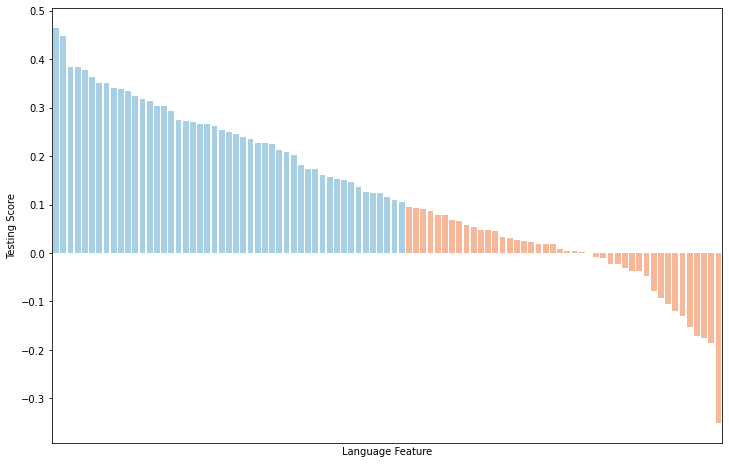

In [112]:
plt.subplots(figsize=(12, 8))
sns.barplot(
    x=all_results_by_score.index,
    y=all_results_by_score.testing_score,
    hue=all_results_by_score.testing_score >= 0.1,
    palette='RdBu',
    saturation=1,
    dodge=False
)
plt.xticks([])
plt.xlabel('Language Feature')
plt.ylabel('Testing Score')
plt.legend([], [], frameon=False)
plt.show()

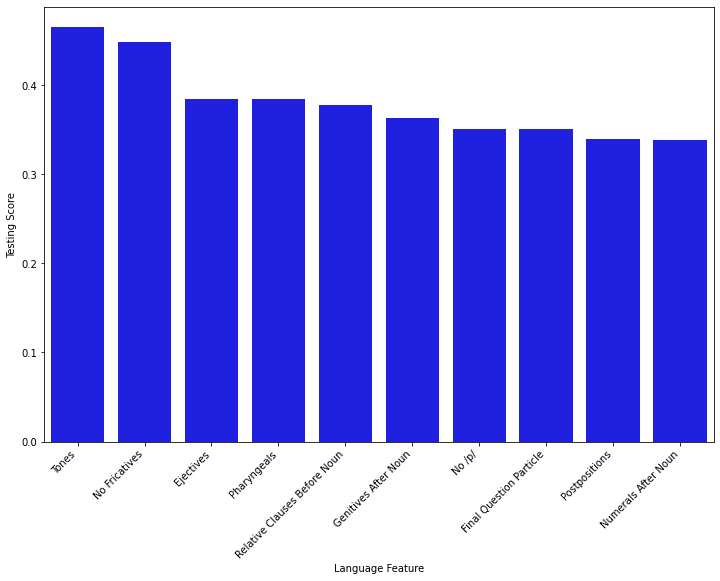

In [118]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    data=all_results_by_score.head(10).reset_index(),
    x='index',
    y='testing_score',
    color='b'
)
plt.xlabel('Language Feature')
plt.ylabel('Testing Score')
ax.set_xticklabels(
    [
        'Tones', 'No Fricatives', 'Ejectives', 'Pharyngeals',
        'Relative Clauses Before Noun', 'Genitives After Noun',
        'No /p/', 'Final Question Particle', 'Postpositions',
        'Numerals After Noun',
    ],
    rotation=45,
    ha='right',
)
plt.show()

In [122]:
all_results_by_odds_shift = all_results[all_results.testing_score >= 0.1].sort_values(
    'log_odds_shift', ascending=False, key=np.abs
)

In [123]:
all_results_by_odds_shift.head()

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
present__labial-velars,0.586480,0.317677,0.057143,0.011750,5.097273,1.628706,-0.347923,2.533667,-0.177405,-1.022055,...,-0.434989,2.414825,-0.269887,-0.226302,-0.098689,-0.140536,-0.159189,0.495833,-0.200251,-0.422984
plurals__prefix,0.336054,0.248603,0.092857,0.037935,2.596025,0.953981,0.735428,1.807400,-0.405293,-0.172023,...,2.024050,1.126320,-0.621919,-0.645517,-0.249148,-0.318416,0.798649,0.099740,-0.436577,1.819418
numerals__after_noun,0.428295,0.338195,0.428571,0.236245,2.424673,0.885697,0.312525,0.953433,-1.079049,-0.597753,...,1.191825,2.755722,-0.176528,1.320907,-0.783774,-0.841990,-1.234386,1.340271,1.320689,-0.352467
genitives__after_noun,0.459867,0.362828,0.325000,0.168224,2.380655,0.867376,2.841330,1.074490,1.273833,1.688275,...,1.548079,0.942101,-0.710822,-1.481839,-0.906210,0.788358,2.564907,-1.798026,0.849200,0.093642
relative_clauses__after_noun,0.372682,0.235500,0.603571,0.425708,2.053925,0.719753,1.401382,1.671342,1.326518,0.544639,...,0.593153,1.684743,0.146367,1.842824,-1.507099,1.499393,2.078715,-0.291884,0.686310,-0.127679


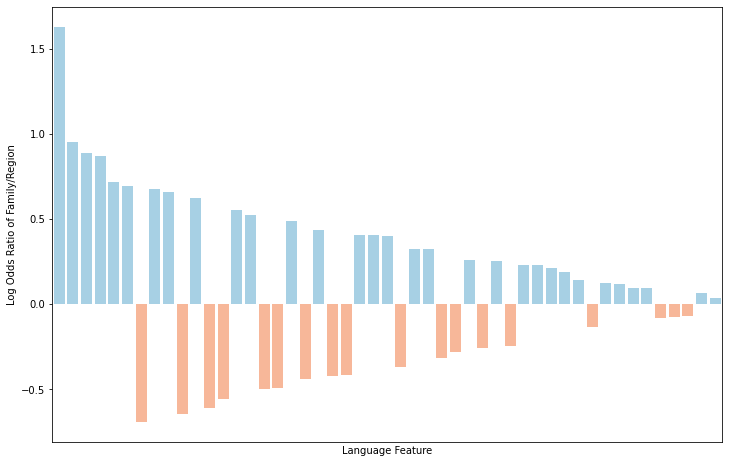

In [127]:
plt.subplots(figsize=(12, 8))
sns.barplot(
    x=all_results_by_odds_shift.index,
    y=all_results_by_odds_shift.log_odds_shift,
    hue=all_results_by_odds_shift.log_odds_shift >= 0.0,
    palette='RdBu',
    saturation=1,
    dodge=False
)
plt.xticks([])
plt.xlabel('Language Feature')
plt.ylabel('Log Odds Ratio of Family/Region')
plt.legend([], [], frameon=False)
plt.show()

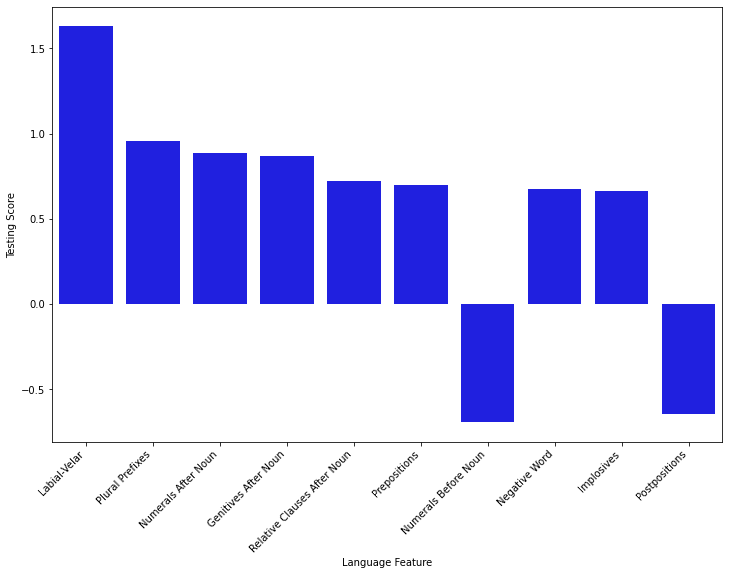

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    data=all_results_by_odds_shift.head(10).reset_index(),
    x='index',
    y='log_odds_shift',
    color='b'
)
plt.xlabel('Language Feature')
plt.ylabel('Testing Score')
ax.set_xticklabels(
    [
        'Labial-Velar', 'Plural Prefixes', 'Numerals After Noun',
        'Genitives After Noun', 'Relative Clauses After Noun',
        'Prepositions', 'Numerals Before Noun', 'Negative Word',
        'Implosives', 'Postpositions',
    ],
    rotation=45,
    ha='right',
)
plt.show()

### Predicting cluster labels

In [52]:
cluster_df = pd.DataFrame(index=origins_df.index)
for clusters in ['cluster2', 'cluster3', 'cluster5', 'cluster9']:
    cluster_df = cluster_df.join(pd.read_csv(f'{clusters}.csv', index_col=0))

In [53]:
cluster_df

,cluster2,cluster3,cluster5,cluster9
Language_ID,,,,
abi,2,3,5,9
abk,1,1,2,4
aco,2,3,5,9
aeg,2,3,4,7
ain,1,1,2,2
...,...,...,...,...
yur,2,3,5,9
zan,2,2,3,6
zqc,1,1,2,4


In [54]:
onehot = OneHotEncoder()

In [55]:
cluster_onehot = pd.DataFrame(
    onehot.fit_transform(cluster_df).todense(),
    index=origins_df.index,
    columns=[
        f'{column}_{value}'
        for column in cluster_df.columns
        for value in sorted(cluster_df[column].unique())
    ]
)

In [56]:
cluster_dataset = origins.OriginDataset(cluster_onehot, origins_good, good_categories)

In [57]:
cluster_results = cluster_dataset.full_logistic_model(cv=True)

In [58]:
cluster_results

,training_score,testing_score,observed_rate,innate_rate,odds_shift,log_odds_shift,Austronesian,Niger-Congo,Indo-European,Afro-Asiatic,...,Bantoid,Africa,Andes/Amazon,Australia,Caucasus,Europe,Mexico,New Guinea,Southeast Asia,USA/Canada
cluster2_1,0.402682,0.214678,0.460714,0.591787,0.589297,-0.528826,-2.632844,-2.310293,0.014770,-0.311275,...,-0.506180,-0.570440,0.548716,-1.797917,1.215086,-2.213288,-1.667130,1.394429,-0.642321,-0.575956
cluster2_2,0.402682,0.214678,0.539286,0.408213,1.696938,0.528826,2.632844,2.310293,-0.014770,0.311275,...,0.506180,0.570440,-0.548716,1.797917,-1.215086,2.213288,1.667130,-1.394429,0.642321,0.575956
cluster3_1,0.402682,0.214678,0.460714,0.591787,0.589297,-0.528826,-2.632844,-2.310293,0.014770,-0.311275,...,-0.506180,-0.570440,0.548716,-1.797917,1.215086,-2.213288,-1.667130,1.394429,-0.642321,-0.575956
cluster3_2,0.469928,0.487316,0.217857,0.072373,3.570091,1.272591,1.183786,2.800677,-0.592320,0.335678,...,1.003693,2.264413,-0.057734,1.214566,-0.386944,-0.463514,-0.625913,0.362107,2.279985,-1.205659
cluster3_3,0.363860,0.290404,0.321429,0.313406,1.037722,0.037027,1.207693,-1.161682,0.223100,0.186328,...,-0.423442,-1.504785,-0.500807,0.799548,-1.065237,2.350263,1.969742,-1.770702,-1.285527,0.951893
cluster5_1,0.370386,-0.045779,0.189286,0.135524,1.489313,0.398315,-1.347480,-1.349298,-0.718787,-0.192738,...,-0.240282,0.478985,0.362724,-0.284690,-0.484091,-0.561518,-0.778174,2.053141,0.369586,-0.866932
cluster5_2,0.328055,0.315312,0.271429,0.405065,0.547177,-0.602982,-2.033221,-1.574416,0.457544,0.030034,...,-0.451137,-1.054678,0.456829,-1.864687,1.512711,-1.980987,-1.138894,-0.697814,-0.951650,-0.060158
cluster5_3,0.469928,0.487316,0.217857,0.072373,3.570091,1.272591,1.183786,2.800677,-0.592320,0.335678,...,1.003693,2.264413,-0.057734,1.214566,-0.386944,-0.463514,-0.625913,0.362107,2.279985,-1.205659
cluster5_4,0.400094,0.293914,0.139286,0.102848,1.411621,0.344738,2.752102,-0.874103,-0.714738,0.692643,...,-0.231543,-0.553243,-0.315291,-1.053265,-0.482317,-0.558430,2.239058,-1.236553,-0.948554,0.901897
cluster5_5,0.411539,0.299025,0.182143,0.165119,1.126062,0.118726,-1.804308,-0.699904,0.690399,-0.706440,...,-0.314639,-1.795559,-0.195825,1.757535,-0.793409,2.650861,0.349410,-1.464427,-0.798359,0.740838
